<a href="https://colab.research.google.com/github/VictorBorzov/traffic_flows_research/blob/master/traffic_flow_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Восстановление матрицы корреспонденций

## Загрузка данных, количества выездов из округов домножаем на поправочный к-т = 1.62

In [1]:
from google.colab import files
files.upload()

Saving trips.csv to trips.csv


{u'trips.csv': '1,1,40,26,2.2\r\n1,2,4,49,8.1\r\n1,3,3,35,6.8\r\n1,4,2,75,9.3\r\n1,5,2,30,8\r\n1,6,4,52,9.9\r\n1,7,6,48,13\r\n1,8,3,48,12.3\r\n1,11,1,30,16.9\r\n1,13,2,50,21.9\r\n2,1,29,53,8.3\r\n2,2,51,27,1.6\r\n2,3,5,51,9\r\n2,4,5,55,15.8\r\n2,5,5,58,18\r\n2,6,5,65,20.3\r\n2,7,1,30,16.5\r\n2,8,8,71,12.9\r\n2,9,6,72,7\r\n2,12,1,60,38.9\r\n2,15,6,48,14\r\n3,1,28,53,11.9\r\n3,2,11,67,8.8\r\n3,3,55,34,1.9\r\n3,4,8,57,12.8\r\n3,5,3,67,18.2\r\n3,6,5,86,22.4\r\n3,7,3,85,19.2\r\n3,8,4,85,17.4\r\n3,9,2,90,12.7\r\n3,11,3,52,14.3\r\n3,12,1,90,19.7\r\n3,14,1,165,54.1\r\n3,15,2,98,20.2\r\n4,1,31,55,9.7\r\n4,2,6,77,12.6\r\n4,3,4,36,9\r\n4,4,36,37,2.2\r\n4,5,5,52,8.8\r\n4,6,3,35,13.8\r\n4,7,4,70,21.4\r\n4,8,4,79,17.8\r\n4,9,2,112,22\r\n4,12,2,90,9\r\n4,13,1,90,29.9\r\n5,1,27,60,11.4\r\n5,2,6,82,19.7\r\n5,3,4,70,20.9\r\n5,4,7,48,7.9\r\n5,5,38,31,1.8\r\n5,6,12,60,8.4\r\n5,7,3,58,12.1\r\n5,8,6,83,16.8\r\n5,9,4,59,23\r\n5,11,1,90,29.8\r\n5,12,4,41,12.3\r\n5,19,1,240,58.1\r\n6,1,22,66,13\r\n6,2,11,66,20

In [0]:
import pandas as pd

In [0]:
data = pd.read_csv('trips.csv', names = ['departure', 'arrival', 'count', 'time', 'dist'])

In [4]:
data[:5]

,departure,arrival,count,time,dist
0,1,1,40,26,2.2
1,1,2,4,49,8.1
2,1,3,3,35,6.8
3,1,4,2,75,9.3
4,1,5,2,30,8.0


In [0]:
data.loc[data['departure'] > 10, 'count'] = data['count'] * 1.62

In [0]:
import numpy as np

## Начальные вектора A, B, калибровочные веса выезда и въезда для каждого пункта, инициализируем единицами:


In [0]:
def init_regions_count(data):
  if len(data['arrival'].unique()) == len(data['departure'].unique()):
    return len(data['arrival'].unique())                                
  else:
    raise Exception('arrivals count <> departures count')                                      
                                     
def A_init():
  return np.ones((regions_count))

def B_init():
  return np.ones((regions_count))

regions_count = init_regions_count(data)

In [0]:
# все функции будем писать в одномерном виде
# выполнив map_regions(функция) будем получать матрицу, 
# в которой [i, j] элемент - функция (i + 1 регион, j + 1 регион)
def map_regions(function):
  regions = np.array([[[i, j] for j in range(1, regions_count + 1)] for i in range(1, regions_count + 1)])
  return np.array([map(function, pair_regions) for pair_regions in [[[i, j] for j in range(1, regions_count + 1)] for i in range(1, regions_count + 1)]])

## Вектора поездок L, W
Вектора L и W - вектора количеств выездов и въездов в округа:
W[i] = количество въезд в i + 1 округ

In [10]:
def W_init():
  W = []
  for j in range(regions_count):
    W.append(np.sum(data.loc[data.arrival == j + 1, 'count']))
  return W

def L_init():
  L = []  
  for i in range(regions_count):
    L.append(np.sum(data.loc[data.departure == i + 1, 'count']))
  return L

W = W_init()
L = L_init()
print np.sum(L), np.sum(W)

2576.94 2576.9400000000005


## Метод Синхорна:
$$A^{n + 1}_i = \left(\sum_{j=1}^n{\frac{B^n_j * W_j}{costs_{ij}}}\right)^{-1}$$
$$B^{n + 1}_j = \left(\sum_{i=1}^n{\frac{A^{n + 1}_i * L_i}{costs_{ij}}}\right)^{-1}$$
$costs_{ij} - издержки\, поездки \, из\, i \, в \, j$

In [0]:
def A_next(B_prev, costs):
  A_next = np.zeros((regions_count)) 
  for i in range(regions_count):
    A_next[i] = ( np.sum(B_prev * W / costs[i, :]) ) ** -1
  return A_next

In [0]:
def B_next(A_curr, costs):
  B_next = np.zeros((regions_count))
  for j in range(regions_count):
    B_next[j] = np.sum(A_curr * L / costs[:, j]) ** -1
  return B_next

In [0]:
def sinkhorn(costs, epochs = 2):
  A = A_init()
  B = B_init()
  i = 1
  while i <= epochs:
    A = A_next(B, costs)
    B = B_next(A, costs)
    i += 1
  return A, B

## Матрица корреспонденций D:
$$d_{ij} = \frac{A_i * B_j * L_i * W_j}{costs_{ij}}$$

In [0]:
def get_counts_predicted(costs):
  A, B = sinkhorn(costs)
  def get_d(couple_regions):
    i = couple_regions[0]
    j = couple_regions[1]
    return (A[i - 1] * B[j - 1] * L[i - 1] * W[j - 1]) / costs[i - 1, j - 1]
  D = map_regions(get_d)
  return D

## Оптимизируемый функционал:
$$\frac{\sum_{j}^n{\sum_{i}^n{(\hat{d_i,_j} - d_i,_j) ^ 2}}}{n^2} \to \min_{\alpha > 0}$$
$d_{ij}$ - количество поездок  
$n$ - кол-во областей в поле гравитационной функции



In [0]:
# кол-во поездок из i в j
def get_d_actual(couple_regions):
  i = couple_regions[0]
  j = couple_regions[1]
  count = len(data[(data.departure == i) & (data.arrival == j)]['count'])
  if count == 1:
    return float(data[(data.departure == i) & (data.arrival == j)]['count'])
  else:
    return 0
D_actual = map_regions(get_d_actual)  

In [0]:
def sqerror(costs):
  D_predicted = get_counts_predicted(costs)
  return np.sum((D_actual - D_predicted) ** 2) / D_predicted.ravel().shape

In [0]:
# время поездки из i в j
def get_time(couple_regions):
  i = couple_regions[0]
  j = couple_regions[1]
  count = len(data[(data.departure == i) & (data.arrival == j)]['time'])
  if count == 1:
    return float(data[(data.departure == i) & (data.arrival == j)]['time'])
# если нет поездок возвращаем 1e2
  else :
    return 1e2 
  
# матрица времен поездок
T = map_regions(get_time)

## Вариант 1: 
$ costs = exp(\alpha  T_{ij})$  
$T_{ij} -время \, поездки\ из\ i\ в\ j$

In [0]:
def f_1(alpha):
  costs_1 = np.exp(alpha * T)
  return sqerror(costs_1)

### Дифференциальная эволюция

In [0]:
from scipy.optimize import differential_evolution as de

In [20]:
result_1 = de(f_1, [(0, 10)], disp = True)
print 'min: {}, argmin: {} '.format(result_1.fun, float(result_1.x))

differential_evolution step 1: f(x)= 426.982
min: [27.71390131], argmin: 0.0712122225334 


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


### Полный перебор для $\alpha \in [0, 1]$ с точностью 0.001:

In [0]:
from matplotlib import pyplot as plt

In [0]:
import time

In [23]:
step = 0.001
alphas = np.linspace(0, 1, 1 / step + 1)
start_time = time.time()
results_1 = np.array([f_1(alpha) for alpha in alphas])
print '{}s seconds'.format(round(time.time() - start_time, 3))
print 'the end'

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  


1.741s seconds
the end


In [0]:
results_1 = results_1.reshape((len(alphas)))

Мистер график:

min: 27.7153650662, argmin: m0.071 


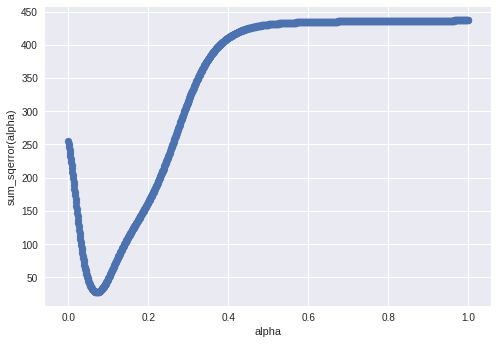

[254.85820113 250.65635298 246.37573821 ... 436.72960643 436.73305183
 436.73649169]


In [25]:
print 'min: {}, argmin: m{} '.format(results_1[np.argmin(results_1)], alphas[np.argmin(results_1)])
plt.scatter(alphas, results_1)
plt.xlabel('alpha')
plt.ylabel('sum_sqerror(alpha)')
plt.show()
print results_1

## Вариант 2: 
$costs = exp(\alpha  T_{ij}^\beta)$  
$T_{ij} -время \, поездки\ из\ i\ в\ j$

In [0]:
def f_2((alpha, beta)):
  costs_2 = np.exp(alpha * (T ** beta))
  return sqerror(costs_2)

### Дифференциальная эволюция

In [0]:
from scipy.optimize import differential_evolution as de

In [28]:
result_2 = de(f_2, [(0, 25), (0, 1)], disp = True)
print 'min: {}, argmin: alpha = {}, beta = {} '.format(result_2.fun, float(result_2.x[0]), float(result_2.x[1]))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


differential_evolution step 1: f(x)= 25.2255
differential_evolution step 2: f(x)= 23.3216
differential_evolution step 3: f(x)= 23.3216
differential_evolution step 4: f(x)= 23.3216
differential_evolution step 5: f(x)= 23.1403
differential_evolution step 6: f(x)= 23.1237
differential_evolution step 7: f(x)= 23.1237
differential_evolution step 8: f(x)= 23.1237
differential_evolution step 9: f(x)= 23.1237
differential_evolution step 10: f(x)= 23.1185
differential_evolution step 11: f(x)= 23.1115
differential_evolution step 12: f(x)= 23.1087
differential_evolution step 13: f(x)= 23.1087
min: [23.10506531], argmin: alpha = 22.0378737185, beta = 0.104717578991 


### Полный перебор для $\alpha \in [0, 10], \beta \in [0, 1]$ с точностями 0.1 и 0.01:

In [0]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from IPython import display
import time

In [30]:
step = 0.01
alphas = np.linspace(0, 10, 1 / step + 1)
betas = np.linspace(0, 1, 1 / step + 1)
start_time = time.time()
results_2 = np.array([[f_2((alpha, beta)) for alpha in alphas] for beta in betas])
print '{}s seconds'.format(round(time.time() - start_time, 3))
print 'the end'    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


18.057s seconds
the end


In [0]:
results_2 = results_2.reshape((len(alphas), len(betas)))
alphas, betas = np.meshgrid(alphas, betas)

Мистер график:

min: 23.3055537969, argmin: alpha = 9.6, beta = 0.18 


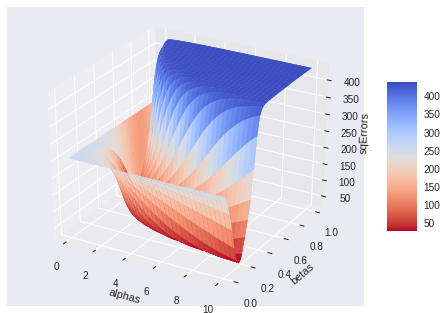

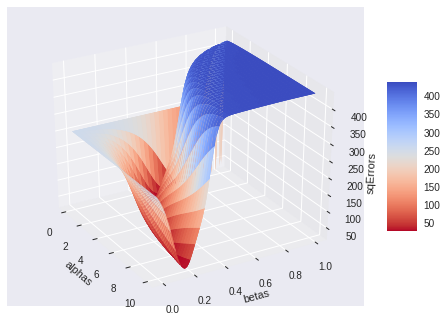

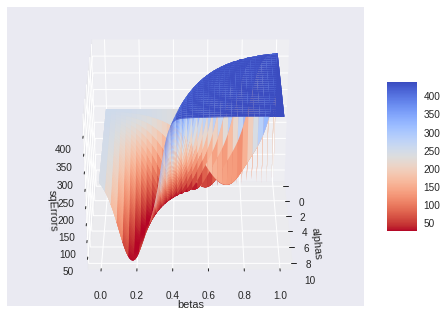

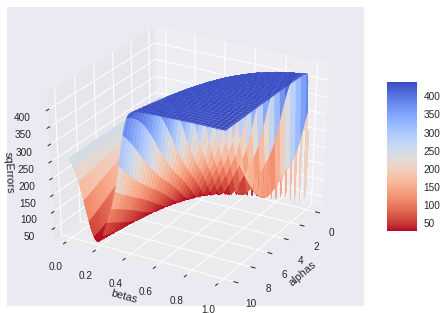

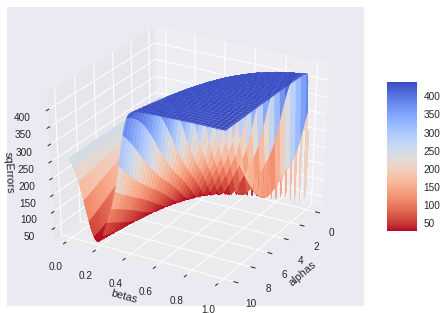

In [32]:
argmin = np.unravel_index(results_2.argmin(), results_2.shape)
print 'min: {}, argmin: alpha = {}, beta = {} '.format(results_2[argmin], alphas[argmin], betas[argmin])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('alphas')
ax.set_ylabel('betas')
ax.set_zlabel('sqErrors')
surf = ax.plot_surface(alphas, betas, results_2, cmap = cm.coolwarm_r)
fig.colorbar(surf, shrink=0.5, aspect=5)
for angle in range(-60, 60, 30):
  ax.view_init(30, angle)
  surf = ax.plot_surface(alphas, betas, results_2, cmap = cm.coolwarm_r)
  display.display(plt.gcf()) 
#   time.sleep(1)
#   display.clear_output(wait=True)

## Вариант 3: зависимость от расстояний
$$ costs = exp(\alpha  T_{ij}^\beta)$$
$$dist_{ij} - расстояние\ из\ i \ в \ j$$  


In [0]:
# матрица расстояний
def get_dist(couple_regions):
  i = couple_regions[0]
  j = couple_regions[1]
  count = len(data[(data.departure == i) & (data.arrival == j)]['dist'])
  if count == 1:
    return float(data[(data.departure == i) & (data.arrival == j)]['dist'])
  else :
    return 1e2  
Dists = map_regions(get_dist)

### Модифицированный метод Синхорна:
$$A^{n + 1}_i = \left(\sum_{j=1}^n{\frac{B^n_j * W_j * dist_{ij}^\omega}{costs_{ij}}}\right)^{-1}$$
$$B^{n + 1}_j = \left(\sum_{i=1}^n{\frac{A^{n + 1}_i * L_i * dist_{ij}^\omega}{costs_{ij}}} \right)^{-1}$$ 
$dist_{ij} - расстояние\ из\ i \ в \ j$  


In [0]:
def A_next_dists(B_prev, costs, dists_correction):
  A_next = np.zeros((regions_count)) 
  for i in range(regions_count):
    A_next[i] = ( np.sum(B_prev * W * dists_correction[i, :] / costs[i, :]) ) ** -1
  return A_next

In [0]:
def B_next_dists(A_curr, costs, dists_correction):
  B_next = np.zeros((regions_count))
  for j in range(regions_count):
    B_next[j] = np.sum(A_curr * L * dists_correction[:, j] / costs[:, j]) ** -1
  return B_next

In [0]:
def sinkhorn_dists(costs, dists_correction, epochs = 2):
  A = A_init()
  B = B_init()
  i = 1
  while i <= epochs:
    A = A_next_dists(B, costs, dists_correction)
    B = B_next_dists(A, costs, dists_correction)
    i += 1
  return A, B

### Модифицированная матрица корреспонденций D:
$$d_{ij} = \frac{A_i * B_j * L_i * W_j * dist_{ij}^\omega}{costs_{ij}}$$

In [0]:
def get_counts_predicted_dists(costs, dists_correction):
  A, B = sinkhorn_dists(costs, dists_correction)
  def get_d(couple_regions):
    i = couple_regions[0]
    j = couple_regions[1]
    return (A[i - 1] * B[j - 1] * L[i - 1] * W[j - 1] * dists_correction[i - 1, j - 1]) / costs[i - 1, j - 1]
  D = map_regions(get_d)
  return D

In [0]:
def sqerror_dists(costs, dists_correction):
  D_predicted = get_counts_predicted_dists(costs, dists_correction)
  return np.sum((D_actual - D_predicted) ** 2) / D_predicted.ravel().shape

In [0]:
def f_3((alpha, beta, omega)):
  dists_correction = Dists ** omega
  costs_3 = np.exp(alpha * (T ** beta))
  return sqerror_dists(costs_3, dists_correction)

### Дифференциальная эволюция

In [0]:
from scipy.optimize import differential_evolution as de

In [41]:
result_3 = de(f_3, [(0, 23), (0, 0.6), (0, 1)], disp = True)
print 'min: {}, argmin: alpha = {}, beta = {}, omega = {} '.format(result_3.fun, float(result_3.x[0]), float(result_3.x[1]), float(result_3.x[2]))

differential_evolution step 1: f(x)= 38.5339
differential_evolution step 2: f(x)= 31.7996
differential_evolution step 3: f(x)= 27.8332
differential_evolution step 4: f(x)= 27.8332
differential_evolution step 5: f(x)= 23.9151
differential_evolution step 6: f(x)= 23.7614
differential_evolution step 7: f(x)= 23.7614
differential_evolution step 8: f(x)= 23.7614
differential_evolution step 9: f(x)= 23.7614
differential_evolution step 10: f(x)= 23.7614
differential_evolution step 11: f(x)= 23.5573
differential_evolution step 12: f(x)= 23.5573
differential_evolution step 13: f(x)= 23.5573
differential_evolution step 14: f(x)= 23.3378
differential_evolution step 15: f(x)= 23.3378
differential_evolution step 16: f(x)= 23.3378
differential_evolution step 17: f(x)= 23.3378
differential_evolution step 18: f(x)= 23.3378
differential_evolution step 19: f(x)= 23.3378
differential_evolution step 20: f(x)= 23.3378
differential_evolution step 21: f(x)= 23.3331
differential_evolution step 22: f(x)= 23.33

## Вариант 4: Зависимость от расстояний
$ costs = exp(\alpha  T_{ij})$  


In [0]:
def f_4((alpha, omega)):
  dists_correction = Dists ** omega
  costs_4 = np.exp(alpha * T)
  return sqerror_dists(costs_4, dists_correction)

### Дифференциальная эволюция

In [0]:
from scipy.optimize import differential_evolution as de

In [48]:
result_4 = de(f_4, [(0, 2), (0, 1)], disp = True)
print 'min: {}, argmin: alpha = {}, omega = {} '.format(result_4.fun, float(result_4.x[0]), float(result_4.x[1]))

differential_evolution step 1: f(x)= 37.7646
differential_evolution step 2: f(x)= 37.7646
differential_evolution step 3: f(x)= 37.7646
differential_evolution step 4: f(x)= 29.7535
differential_evolution step 5: f(x)= 29.7535
differential_evolution step 6: f(x)= 29.7535
differential_evolution step 7: f(x)= 29.7535
differential_evolution step 8: f(x)= 28.3739
differential_evolution step 9: f(x)= 28.1561
differential_evolution step 10: f(x)= 28.1561
differential_evolution step 11: f(x)= 28.1561
differential_evolution step 12: f(x)= 27.9561
differential_evolution step 13: f(x)= 27.9561
differential_evolution step 14: f(x)= 27.9561
differential_evolution step 15: f(x)= 27.9237
differential_evolution step 16: f(x)= 27.9237
differential_evolution step 17: f(x)= 27.9237
min: [27.71390131], argmin: alpha = 0.0712122214763, omega = 0.0 


### Полный перебор для $\alpha \in [0, 2], \omega \in [0, 1]$ с точностями 0.02 и 0.01:

In [0]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from IPython import display
import time

In [50]:
step = 0.01
alphas = np.linspace(0, 1, 1 / step + 1)
omegas = np.linspace(0, 2, 1 / step + 1)
start_time = time.time()
results_4 = np.array([[f_4((alpha, omega)) for alpha in alphas] for omega in omegas])
print '{}s seconds'.format(round(time.time() - start_time, 3))
print 'the end'    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


20.548s seconds
the end


In [0]:
results_4 = results_4.reshape((len(alphas), len(omegas)))
alphas, omegas = np.meshgrid(alphas, omegas)

Мистер график:

min: 27.7619860892, argmin: alpha = 0.07, omega = 0.0 


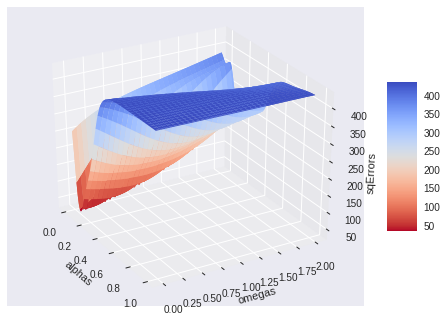

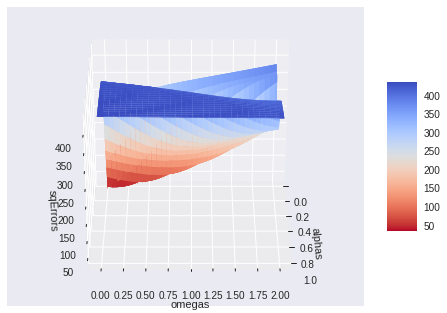

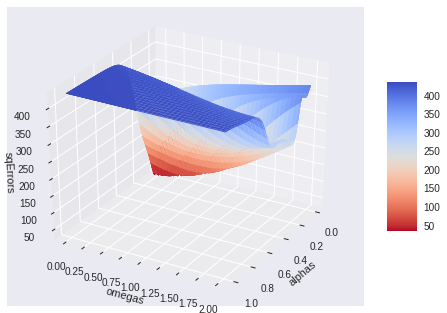

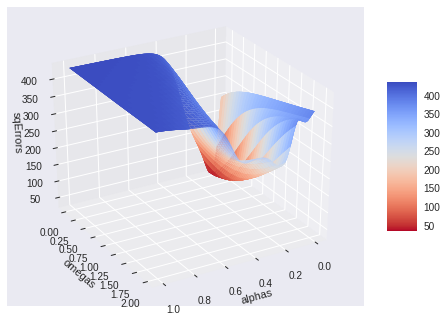

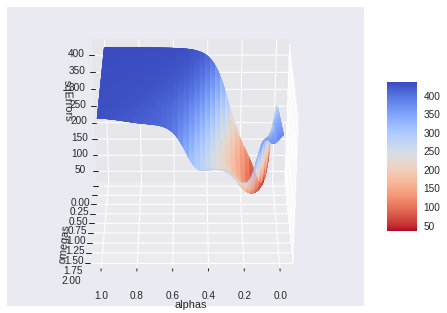

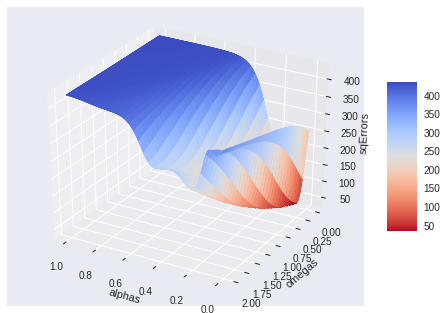

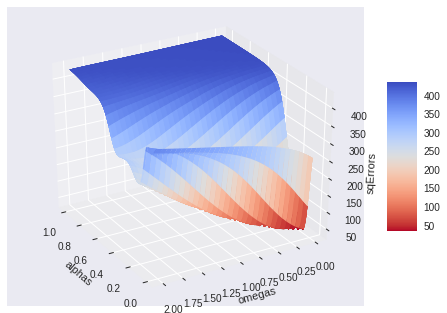

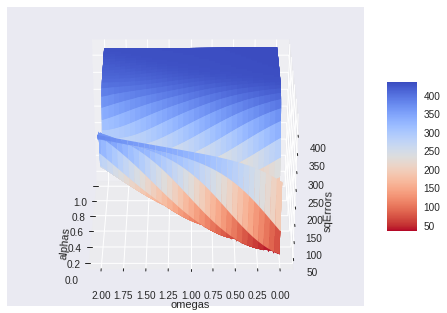

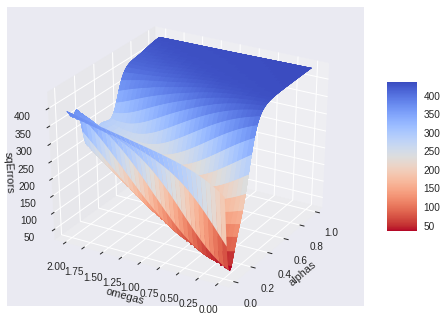

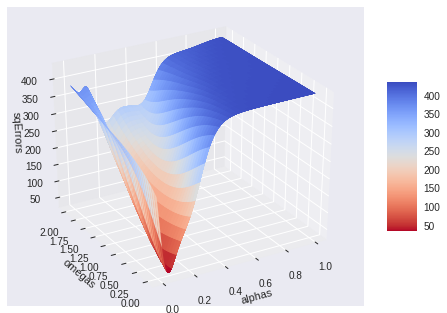

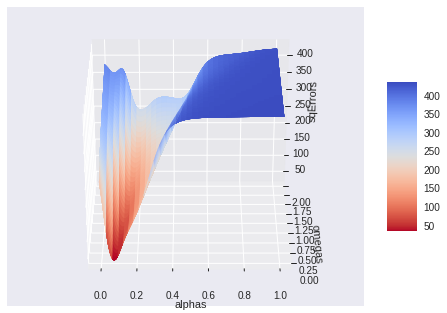

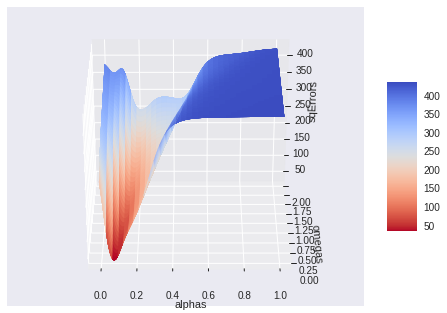

In [52]:
argmin = np.unravel_index(results_4.argmin(), results_4.shape)
print 'min: {}, argmin: alpha = {}, omega = {} '.format(results_4[argmin], alphas[argmin], omegas[argmin])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('alphas')
ax.set_ylabel('omegas')
ax.set_zlabel('sqErrors')
surf = ax.plot_surface(alphas, omegas, results_4, cmap = cm.coolwarm_r)
fig.colorbar(surf, shrink=0.5, aspect=5)
for angle in range(-30, 300, 30):
  ax.view_init(30, angle)
  surf = ax.plot_surface(alphas, omegas, results_4, cmap = cm.coolwarm_r)
  display.display(plt.gcf()) 
#   time.sleep(1)
#   display.clear_output(wait=True)

## Результаты:
1. В лучшем случае этим методом можно получить среднюю ошибку $\approx$ 5 минуты. Т.е. ошибка в основном > 4%. Это довольно неплохо на первый взгляд, хорошо бы провести дополнительную проверку модели на других данный.
2. При оптимизации дифференциальную эволюцию лучше прогонять несколько раз, строить сетку смысла особо не имеет, так картиночки посмотреть.
3. Введение калибровки по расстоянию никакого выигрыша не дает, это было ожидаемо, т.к. это избыточный признак, линейно зависящий от времени, а вот степень $\beta$ полезно отрегулировать.



## Исследование зависимости выигрыша от учитывания степени $\beta$ от размерности задачи. 
n - количество округов

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.optimize import differential_evolution as de

In [0]:
data_original = pd.read_csv('trips.csv', names = ['departure', 'arrival', 'count', 'time', 'dist'])
data_original.loc[data_original['departure'] > 10, 'count'] = data_original['count'] * 1.62
regions_count_original = init_regions_count(data_original)

In [0]:
def reduce_data(n): 
  global data, regions_count, W, L
  data = data_original.loc[(data_original['departure'] <= n) & (data_original['arrival'] <= n)]
  regions_count = init_regions_count(data)
  W = W_init()
  L = L_init()

In [0]:
gains = []
for dimension in range(1, regions_count_original + 1):
  print 'dimension : {}'.format(dimension)
  reduce_data(dimension)
  T = map_regions(get_time)
  D_actual = map_regions(get_d_actual)  
  result_a = 0
  result_ab = 0
  for i in range(5):
    print 'f_1'
    result_a += de(f_1, [(0, 10)]).fun
    print 'f_2'
    result_ab += de(f_2, [(0, 10), (0, 1)]).fun
  result_a /= 5
  result_ab /= 5
  gains.append(result_a / result_ab)  

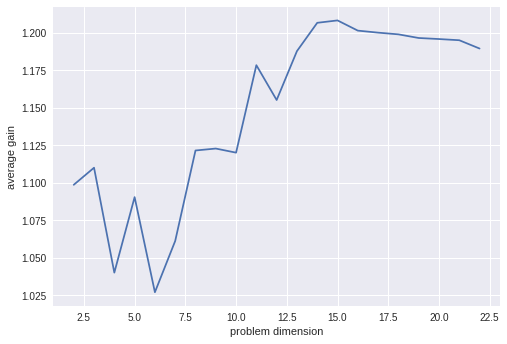

In [0]:
plt.plot(range(1, regions_count_original + 1), gains)
plt.xlabel('problem dimension')
plt.ylabel('average gain')
plt.show()